Epoch [2000/100000], Loss (MSRE) Train: 355.359430, RMSRE Train: 18.850980, Loss (MSRE) Val: 25.709277, RMSRE Val: 5.070432 Learning Rate: 0.08352636
Epoch [4000/100000], Loss (MSRE) Train: 3087.385756, RMSRE Train: 55.564249, Loss (MSRE) Val: 172.925132, RMSRE Val: 13.150100 Learning Rate: 0.0697665
Epoch [6000/100000], Loss (MSRE) Train: 5068.688277, RMSRE Train: 71.194721, Loss (MSRE) Val: 225.687102, RMSRE Val: 15.022886 Learning Rate: 0.05827342
Epoch [8000/100000], Loss (MSRE) Train: 10639.798520, RMSRE Train: 103.149399, Loss (MSRE) Val: 2420.069037, RMSRE Val: 49.194197 Learning Rate: 0.04867368
Epoch [10000/100000], Loss (MSRE) Train: 2840.796200, RMSRE Train: 53.299120, Loss (MSRE) Val: 455.111974, RMSRE Val: 21.333354 Learning Rate: 0.04065531
Epoch [12000/100000], Loss (MSRE) Train: 586.467923, RMSRE Train: 24.217100, Loss (MSRE) Val: 293.592188, RMSRE Val: 17.134532 Learning Rate: 0.03395788
Epoch [14000/100000], Loss (MSRE) Train: 366.832145, RMSRE Train: 19.152863, Loss 

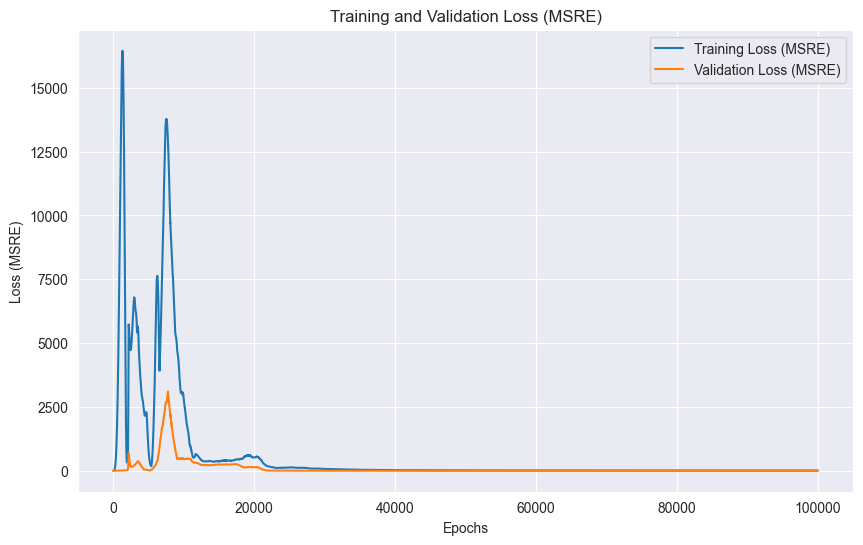

ValueError: x and y must be the same size

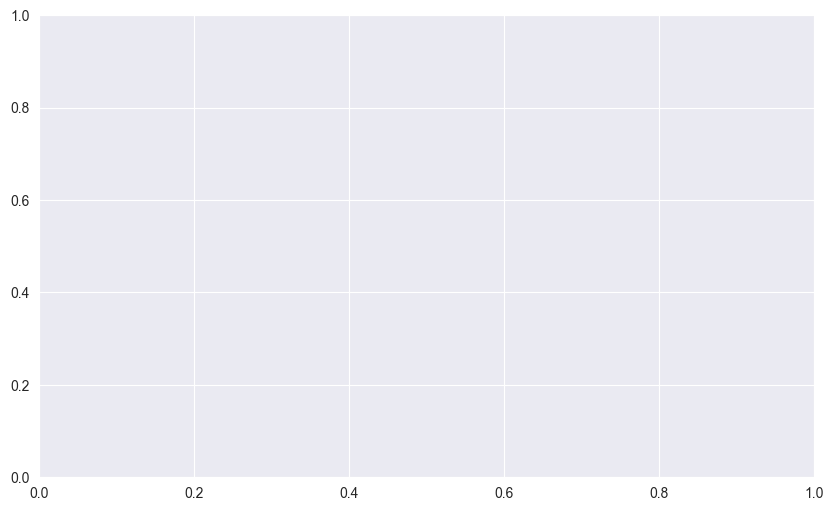

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Constants
g = 9.80665  # Gravitational acceleration (m/s^2)

class WaterWavePredictor:
    def __init__(self, input_size=2, hidden_size=32, output_size=1, learning_rate=1e-1, max_norm=1.0, learning_rate_factor = 0.99991):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.max_norm = max_norm
        self.learning_rate_factor = learning_rate_factor
        self.prev_lossval = 100
        self.W1_backup = None
        self.W1_backup = None
        self.b1_backup = None
        self.b2_backup = None

        # Initialize weights and biases
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * np.sqrt(2. / self.input_size)
        self.b1 = np.zeros(self.hidden_size)
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * np.sqrt(2. / self.hidden_size)
        self.b2 = np.zeros(self.output_size)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(x.dtype)

    def msre_loss(self, outputs, targets, epsilon=1e-8):
        return np.mean(((targets - outputs) / (targets + epsilon)) ** 2)

    def clip_gradient(self, grad):
        norm = np.linalg.norm(grad)
        if norm > self.max_norm:
            grad = grad * (self.max_norm / norm)
        return grad

    def forward(self, X, backup = False):
        if backup:
            Z1 = X.dot(self.W1_backup) + self.b1_backup
            A1 = self.relu(Z1)
            Z2 = A1.dot(self.W2_backup) + self.b2_backup
        else:
            Z1 = X.dot(self.W1) + self.b1
            A1 = self.relu(Z1)
            Z2 = A1.dot(self.W2) + self.b2
        return Z1, A1, Z2

    def backward(self, X, Z1, A1, Z2, y):
        dZ2 = 2 * (Z2 - y.reshape(-1, 1)) / y.size
        dW2 = A1.T.dot(dZ2)
        db2 = np.sum(dZ2, axis=0)

        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * self.relu_derivative(Z1)
        dW1 = X.T.dot(dZ1)
        db1 = np.sum(dZ1, axis=0)

        dW1 = self.clip_gradient(dW1)
        db1 = self.clip_gradient(db1)
        dW2 = self.clip_gradient(dW2)
        db2 = self.clip_gradient(db2)

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X_train, y_train, X_val, y_val, epochs=100000):
        losses_train = []
        losses_val = []

        for epoch in range(epochs):
            Z1_train, A1_train, Z2_train = self.forward(X_train)
            loss_train = self.msre_loss(Z2_train, y_train.reshape(-1, 1))
            losses_train.append(loss_train)

            _, _, Z2_val = self.forward(X_val)
            loss_val = self.msre_loss(Z2_val, y_val.reshape(-1, 1))
            losses_val.append(loss_val)

            self.backward(X_train, Z1_train, A1_train, Z2_train, y_train)
            self.learning_rate *= self.learning_rate_factor
            # Limit the learning rate to 8 decimal places
            self.learning_rate = round(self.learning_rate, 8)
            if self.learning_rate < 1e-8:
                self.learning_rate = 1e-8

            if (epoch + 1) % 2000 == 0:
                rmsre_train = np.sqrt(loss_train)
                rmsre_val = np.sqrt(loss_val)
                print(f'Epoch [{epoch + 1}/{epochs}], Loss (MSRE) Train: {loss_train:.6f}, RMSRE Train: {rmsre_train:.6f}, Loss (MSRE) Val: {loss_val:.6f}, RMSRE Val: {rmsre_val:.6f}', 'Learning Rate:', self.learning_rate)
            
            if loss_val > self.prev_lossval:
                # Export the model weights and biases
                self.W1_backup = self.W1
                self.W2_backup = self.W2
                self.b1_backup = self.b1
                self.b2_backup = self.b2
                
            self.prev_lossval = loss_val
            
        
        return losses_train, losses_val

    def predict(self, X, backup = False):
        _, _, Z2 = self.forward(X, backup = backup)
        return np.sqrt(np.maximum(Z2.flatten(), 0))

    def visualize_losses(self, losses_train, losses_val):
        plt.figure(figsize=(10, 6))
        plt.plot(losses_train, label='Training Loss (MSRE)')
        plt.plot(losses_val, label='Validation Loss (MSRE)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (MSRE)')
        plt.legend()
        plt.title('Training and Validation Loss (MSRE)')
        plt.show()

    def visualize_predictions(self, y_actual, y_train_pred, y_val_pred):
        plt.figure(figsize=(10, 6))
        plt.scatter(y_actual, y_train_pred, color='blue', label='Training Predictions')
        plt.scatter(y_actual, y_val_pred, color='green', label='Validation Predictions')
        plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=4)
        plt.xlabel('Actual Speed (m/s)')
        plt.ylabel('Predicted Speed (m/s)')
        plt.legend()
        plt.title('Actual vs Predicted Wave Speeds (Training and Validation)')
        plt.show()

# Load data from CSV
data = pd.read_csv("water_waves_training_data.csv")
h = data['height'].values
lambda_w = data['wave_length'].values
c = data['speed'].values

# Prepare the features based on c^2 = S(gh, g sqrt(h lambda))
X = np.vstack((g * h, g * np.sqrt(h * lambda_w))).T
y = c**2  # Target is c^2

# Split the data into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using the training set statistics
mean_X = np.mean(X_train, axis=0)
std_X = np.std(X_train, axis=0)
X_train_scaled = (X_train - mean_X) / std_X
X_val_scaled = (X_val - mean_X) / std_X

# Initialize the WaterWavePredictor class
predictor = WaterWavePredictor()

# Train the model
losses_train, losses_val = predictor.train(X_train_scaled, y_train, X_val_scaled, y_val)

# Predictions and denormalization for training and validation sets
predicted_speeds_train = predictor.predict(X_train_scaled)
predicted_speeds_val = predictor.predict(X_val_scaled)

# Visualization - Training vs Validation Loss
predictor.visualize_losses(losses_train, losses_val)

# Visualization - Actual vs Predicted for Training and Validation sets
predictor.visualize_predictions(c, predicted_speeds_train, predicted_speeds_val)



In [22]:
# Load the verification data
verification_data = pd.read_csv('water_waves_verification_data_input.csv')
h_ver = verification_data['h'].values
lambda_w_ver = verification_data['lam'].values

# Transform the verification data
X_ver = np.vstack((g * h_ver, g * np.sqrt(h_ver * lambda_w_ver))).T

# Normalize the features using the mean and std from the training data
X_ver_scaled = (X_ver - mean_X) / std_X

# Predict using the trained model
expected_speed = predictor.predict(X_ver_scaled, backup = True)

# Prepare the submission DataFrame
submission = pd.DataFrame({
    'id': verification_data['id'],
    'expected': expected_speed
})

# Check if submission has null values
print(submission.isnull().values.any())

# Print the final RMSE
# print(np.sqrt(np.mean((expected_speed - verification_data['c'])**2)))

# Print the submission DataFrame
print(submission)

# Create CSV file for submission
submission.to_csv('submission_approach_with_class2.csv', index=False)

False
      id    expected
0      0  369.562617
1      1   37.713283
2      2   32.992115
3      3   49.097166
4      4  366.333366
..   ...         ...
195  195   33.501221
196  196   72.179152
197  197  183.338375
198  198   44.944615
199  199   19.067561

[200 rows x 2 columns]


In [15]:
predictor.W1

array([[ 4.13245833e-01,  4.42449528e+00, -2.01676643e+00,
         4.00681277e+00,  1.12765892e+01, -6.30683749e-01,
         9.58320698e+00,  7.51158647e-01,  1.26154035e+01,
         5.19626005e+00, -3.52850304e-01,  1.12426806e+01,
        -1.75659859e+00, -3.74974296e-01,  5.86958841e+00,
         5.31095839e-01,  5.66110465e-01,  8.23523064e+00,
        -7.68073037e-01,  7.76646936e+00, -3.97654160e+00,
         4.44271261e-02, -1.05849882e+00,  5.87800126e+00,
         3.20924182e+00,  4.52589381e+00, -1.43671339e+00,
         1.14121181e+01,  3.41002493e-01, -6.03761432e-01,
         8.72637880e+00,  7.08491848e+00],
       [-6.13162263e-01,  1.94817187e+01,  9.59858089e+00,
         1.45344927e+01,  4.64094003e+01, -1.87838073e-01,
         3.48393780e+01, -1.78591334e+00,  4.24618039e+01,
         1.45196760e+01,  1.36412130e-01,  3.70992056e+01,
        -9.45997537e-01,  8.86487744e-01,  2.37145080e+01,
        -5.29498814e-01, -8.94934739e-01,  2.69433660e+01,
         3.53